###### <img src="Electronic_Brain.png" width="200" style="float:left">
<h1> Spring 2021 ML Course.</h1>
<h2> Exercise 14: Ensemble Uncertainty Estimation<br>Tools: CatBoost</h2>

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier

import icecream as ic
from tqdm import tqdm

import matplotlib as plt
import matplotlib.pyplot as plt

In [2]:
ensemble_size = 10
num_delays = 20

<img src="desktop-computer-icon.png" width="90" style="float:left; margin-right: 10px;">
<h1> &nbsp; Section A: Signal Generation.</h1>

In [3]:
"""
# Generate daily stock prices.
# This function generates a sequence of segments, each comprising Brownian geometric "motion"
# with a given mean & variance and num. of steps.
"""
def generate_stock_prices(params, seed, add_tail=False):

    rng = np.random.default_rng(seed)
    curr_price = 100
    price_seq = [curr_price]
    color_seq = [0]
    
    # Outer loop over regimes:
    for [mu, sigma, steps] in params:
        
        # Inner loop over days in the regime.
        # WARNING: absolutely inefficient, only for demonstration! 
        for i in range(steps):
            daily_move = mu + rng.normal(0, sigma)
            next_price = curr_price * daily_move
            price_seq.append(next_price)
            color_seq.append(np.sign(1 - mu))
            curr_price = next_price

    # Maybe we wish to add a "tail" which behaves completely differently.
    if add_tail==True:
        for i in range(5*steps):
            daily_move = 1 + rng.normal(0, 0.1*sigma)
            next_price = curr_price * daily_move
            price_seq.append(next_price)
            color_seq.append(3)
            curr_price = next_price
    
    # Turn the whole thing into a Pandas dataframe and return it.
    # NOTICE we set the dataframe index to the day seq. num. to enable merges between stocks.
    prices_df = pd.DataFrame()
    prices_df['AAPL'] = price_seq
    prices_df['day_seqno'] = range(len(price_seq))
    prices_df['colors'] = np.array(color_seq)
    prices_df.set_index('day_seqno')

    # Form log-return "features" (num_delays of them), composed of the log-diff prices.
    log_rets_df = pd.DataFrame()
    log_rets_df['colors'] = prices_df['colors']
    for delay in range(num_delays):
        log_rets_df['AAPL_log_ret_' + str(delay)] = np.log(prices_df['AAPL']) - np.log(prices_df['AAPL'].shift(periods=delay))
    log_rets_df.dropna(inplace=True)
    
    # print("Seed:", seed, "checksum:", np.sum(price_seq), "feat length:", len(log_rets_df), "price length:", len(prices_df), "max color:", log_rets_df['colors'].max())
    return(prices_df, log_rets_df)

In [4]:
# All stocks share the same Brownian params but the regimes are of random duration.
# We always start off with an UP leg.
noise_sigma = 0.0125
return_params = []
for _ in range(10):
    return_params.append([1.007, noise_sigma, 100])
    return_params.append([0.996, noise_sigma, 100])

regime_lengths = np.array([rp[2] for rp in return_params])
regime_start_days = np.cumsum(regime_lengths)

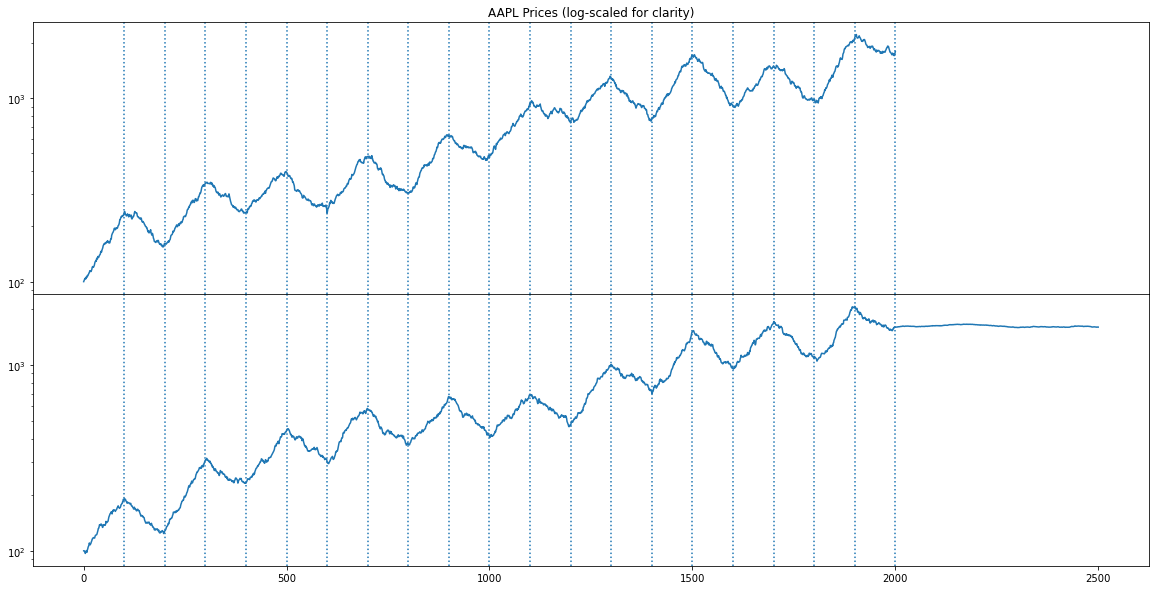

In [5]:
# Construct two series: one without and one with a "tail".
prices_train_df, _ = generate_stock_prices(return_params, seed=1701)
prices_tail_df, _ = generate_stock_prices(return_params, seed=2045, add_tail=True)

# Show off the time series.
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].plot(prices_train_df['AAPL'], label='AAPL')
axs[1].plot(prices_tail_df['AAPL'], label='AAPL')

# Show the actual regime transition days.
for regime_start_day in regime_start_days:
    axs[0].axvline(regime_start_day, linestyle=':')
    axs[1].axvline(regime_start_day, linestyle=':')

axs[0].set(xlabel='Day Seq. Number', title='AAPL Prices (log-scaled for clarity)');

In [6]:
"""
Define an "ensemble" class, which internally holds a given number (esize) of CatBoost classifiers.
The class can fit and predict (all its internal classifiers) using the standard sklearn API.
Using this class, the additional functions (below it) evaluate three distinct measures of uncertainty:
* Total uncertainty via entropy_of_expected()
  The sum of the two parts below.
* Data uncertainty (a.k.a aleatoric uncertainty) via expected_entropy()
  This part of the uncertainty should (in theory) measure the extent of uncertainty "inherent" to the process.
  It should *not* decrease as more data becomes available.
* Knowledge uncertainty (a.k.a epistemic uncertainty) via mutual_information()
  This part is due to the limited availability of data.
  In practice, of course, the separation of the two is hardly "clean", but sometimes useful.

Ensemble class and functions below adapted from Yandex' CatBoost team's (*** BUGGY ***) notebook:
https://github.com/yandex-research/GBDT-uncertainty/blob/main/synthetic_classification.ipynb
"""
class Ensemble(object):
    
    def __init__(self, esize=10, iterations=1000, lr=0.1, random_strength=0, border_count=128, depth=6, seed=100):
        
        self.seed = seed
        self.esize = esize
        self.depth = depth
        self.iterations=iterations
        self.lr=lr
        self.random_strength = random_strength
        self.border_count = border_count
        self.ensemble = []
        for e in range(self.esize):
            model = CatBoostClassifier(
                iterations=self.iterations,
                depth=self.depth,
                learning_rate=self.lr,
                border_count=self.border_count,
                random_strength=self.random_strength,
                loss_function='MultiClass',
                silent=True,
                bootstrap_type='No',
                posterior_sampling=True,
                langevin=True,
                random_seed=self.seed + e)
            self.ensemble.append(model)
        
    def fit(self, X, y):
        for m in tqdm(self.ensemble):
            m.fit(X, y)
            # print("best score ", m.get_best_score())
    
    def predict(self,x):
        probs = []
        for m in self.ensemble:
            prob = m.predict_proba(x)
            probs.append(prob)
        probs = np.stack(probs)
        return probs
    
def entropy_of_expected(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)

def expected_entropy(probs, epsilon=1e-10):
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)

def mutual_information(probs, epsilon):
    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)
    return eoe - exe

def ensemble_uncertainties(probs, epsilon=1e-10):
    mean_probs = np.mean(probs, axis=0)
    conf = np.max(mean_probs, axis=1)
    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)
    mutual_info = eoe - exe
    uncertainty = {
        'confidence': conf,
        'entropy_of_expected': eoe,
        'expected_entropy': exe,
        'mutual_information': mutual_info,
    }
    return uncertainty

<img src="desktop-computer-icon.png" width="90" style="float:left; margin-right: 10px;">
<h1> &nbsp; Section B: Ensemble uncertainty estimation.</h1>
We proceed to re-create the scenario of exercise 11 (dimensionality reduction).<br>
This time, however, we use the ensemble both as a "normal" classifier and as an (aleatoric / epistemic) uncertainty estimator.

In [7]:
# Re-generate the prices and features.
prices_train_df, log_rets_train_df = generate_stock_prices(return_params, seed=1701)
prices_test_df, log_rets_test_df = generate_stock_prices(return_params, seed=2021)
prices_tail_df, log_rets_tail_df = generate_stock_prices(return_params, seed=2045, add_tail=True)

# In this exercise, we use all the features all the time.
used_features = ['AAPL_log_ret_' + str(delay) for delay in range(num_delays)]

# Initialize an ensemble, fit it using the training set features.
ens = Ensemble(esize=ensemble_size, iterations=1000, lr=0.1, depth=6, seed=2, random_strength=100)
X_train = log_rets_train_df[used_features].to_numpy()
y_train = log_rets_train_df[['colors']].to_numpy()
ens.fit(X_train, y_train)

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


In [8]:
# Generate classification and uncertainty probabilities on the test set.
X_test = log_rets_test_df[used_features].to_numpy()
y_test = log_rets_test_df[['colors']].to_numpy()
test_probs = ens.predict(X_test)

# Generate classification and uncertainty probabilities on the "tail" test set.
X_tail = log_rets_tail_df[used_features].to_numpy()
y_tail = log_rets_tail_df[['colors']].to_numpy()
tail_probs = ens.predict(X_tail)

# Extract mean predictions (mean across the ensemble).
mean_test_probs = np.mean(test_probs, axis=0)
mean_tail_probs = np.mean(tail_probs, axis=0)

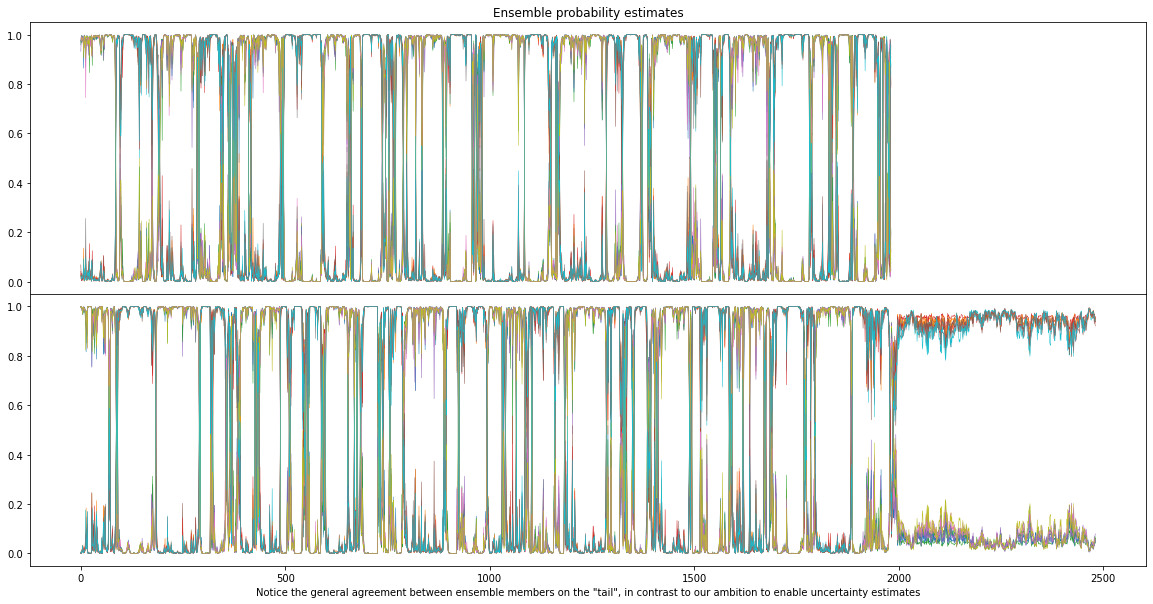

In [16]:
# Show off the time series.
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].set(xlabel='Day Seq. Number', title='Ensemble probability estimates')
axs[1].set(xlabel='Notice the general agreement between ensemble members on the "tail", in contrast to our ambition to enable uncertainty estimates')
# Show each member's predictions separately.
for i in range(ensemble_size):
    axs[0].plot(test_probs[i,:], linewidth=0.5)
    axs[1].plot(tail_probs[i,:], linewidth=0.5)

[Text(0.5, 0, 'The decomposition into aleatoric / epistemic uncertainties is not helpful.')]

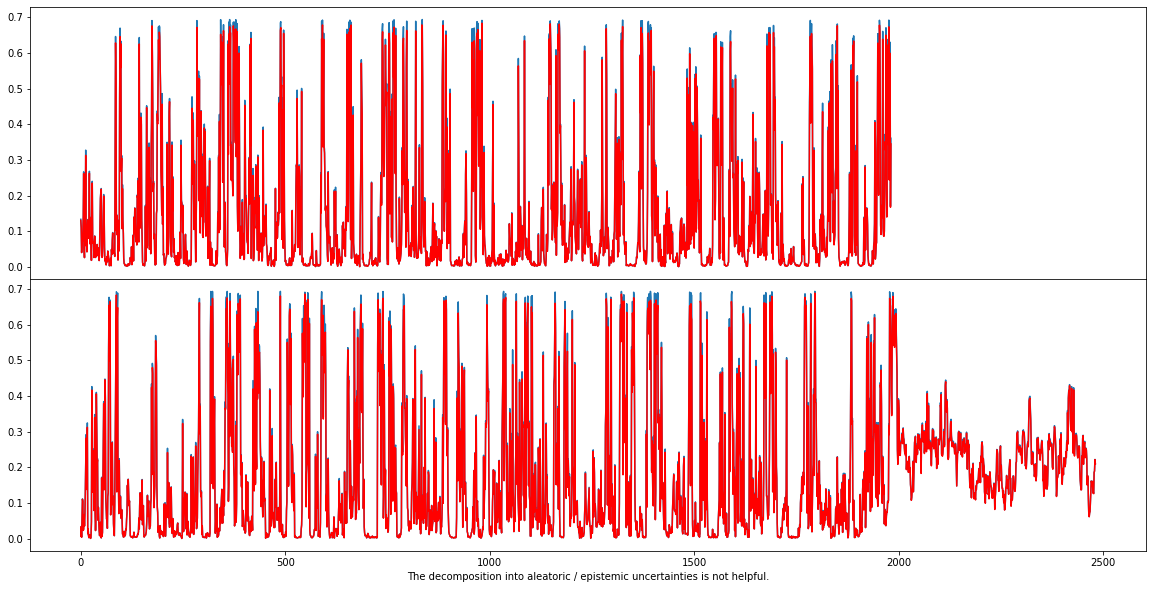

In [15]:
# Generate the ensemble uncertainty estimates.
uncerts_test = ensemble_uncertainties(test_probs)
uncerts_tail = ensemble_uncertainties(tail_probs)

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

# Show each member's predictions separately.
axs[0].plot(uncerts_test['entropy_of_expected'])
axs[1].plot(uncerts_tail['entropy_of_expected'])

axs[0].plot(uncerts_test['expected_entropy'], 'r')
axs[1].plot(uncerts_tail['expected_entropy'], 'r');
axs[1].set(xlabel='The decomposition into aleatoric / epistemic uncertainties is not helpful.');